In [5]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np
from  matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns

In [7]:
#def a function to create cumulative dict for countries
def cum_count(D):
    cum_count_D = {}
    # Loop over each key in the original dictionary
    for key, value in D.items():
        # Extract the prefix (the part before the underscore)
        prefix = key.split('_')[0]
    
        # Sum the values for each prefix
        if prefix in cum_count_D:
            cum_count_D[prefix] += value
        else:
            cum_count_D[prefix] = value
    return cum_count_D

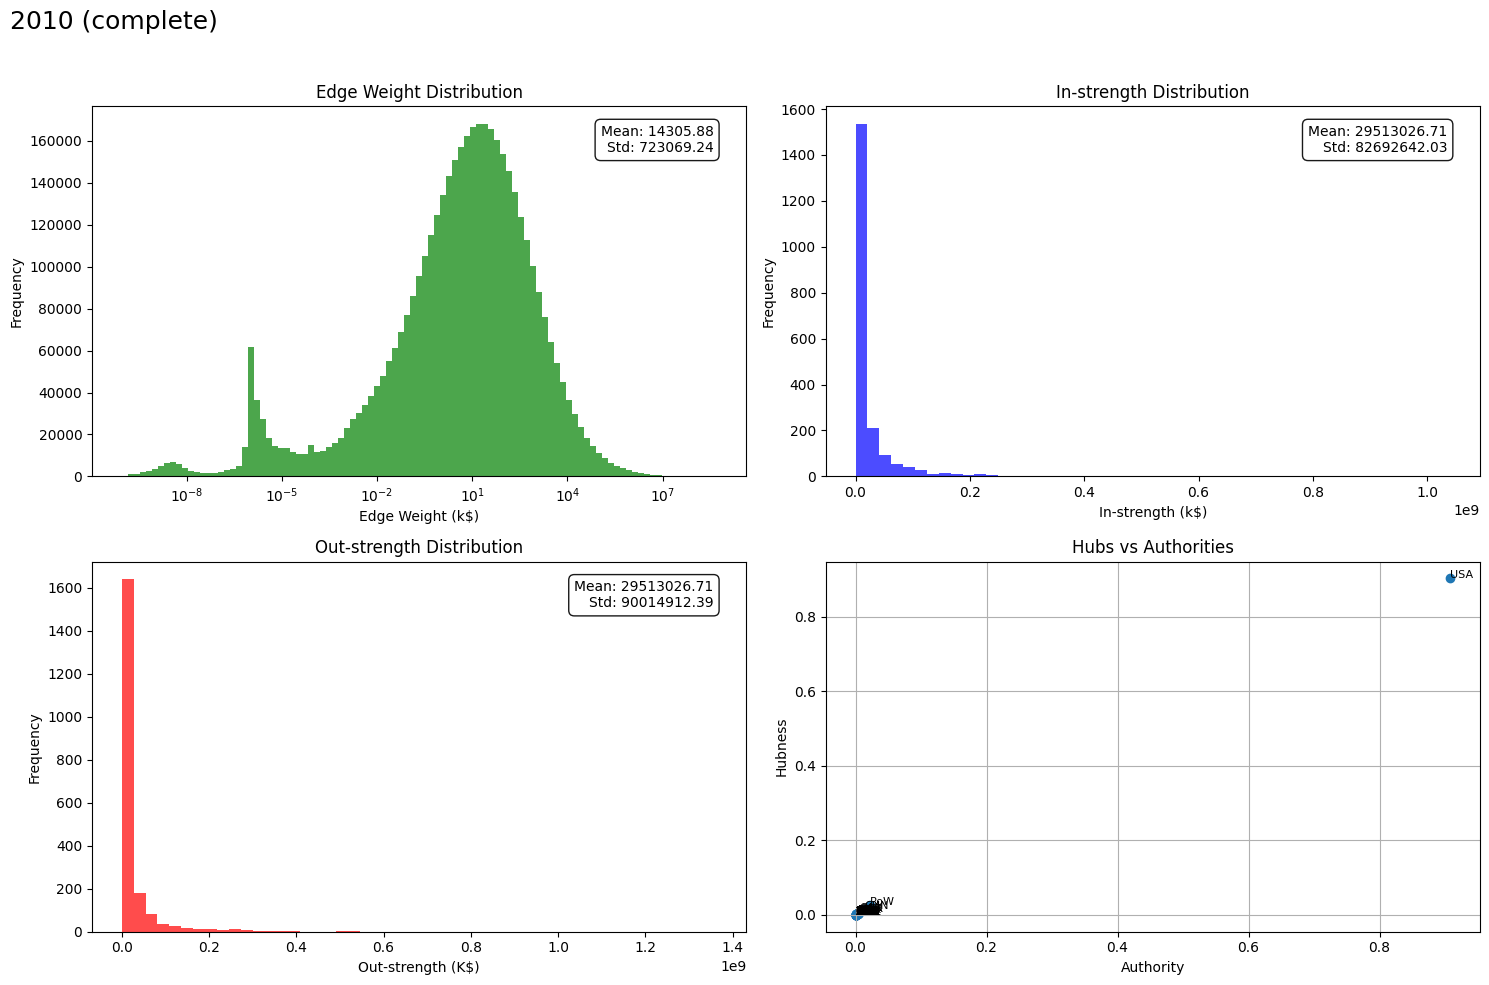

Saved: hub_aut_2010.parquet


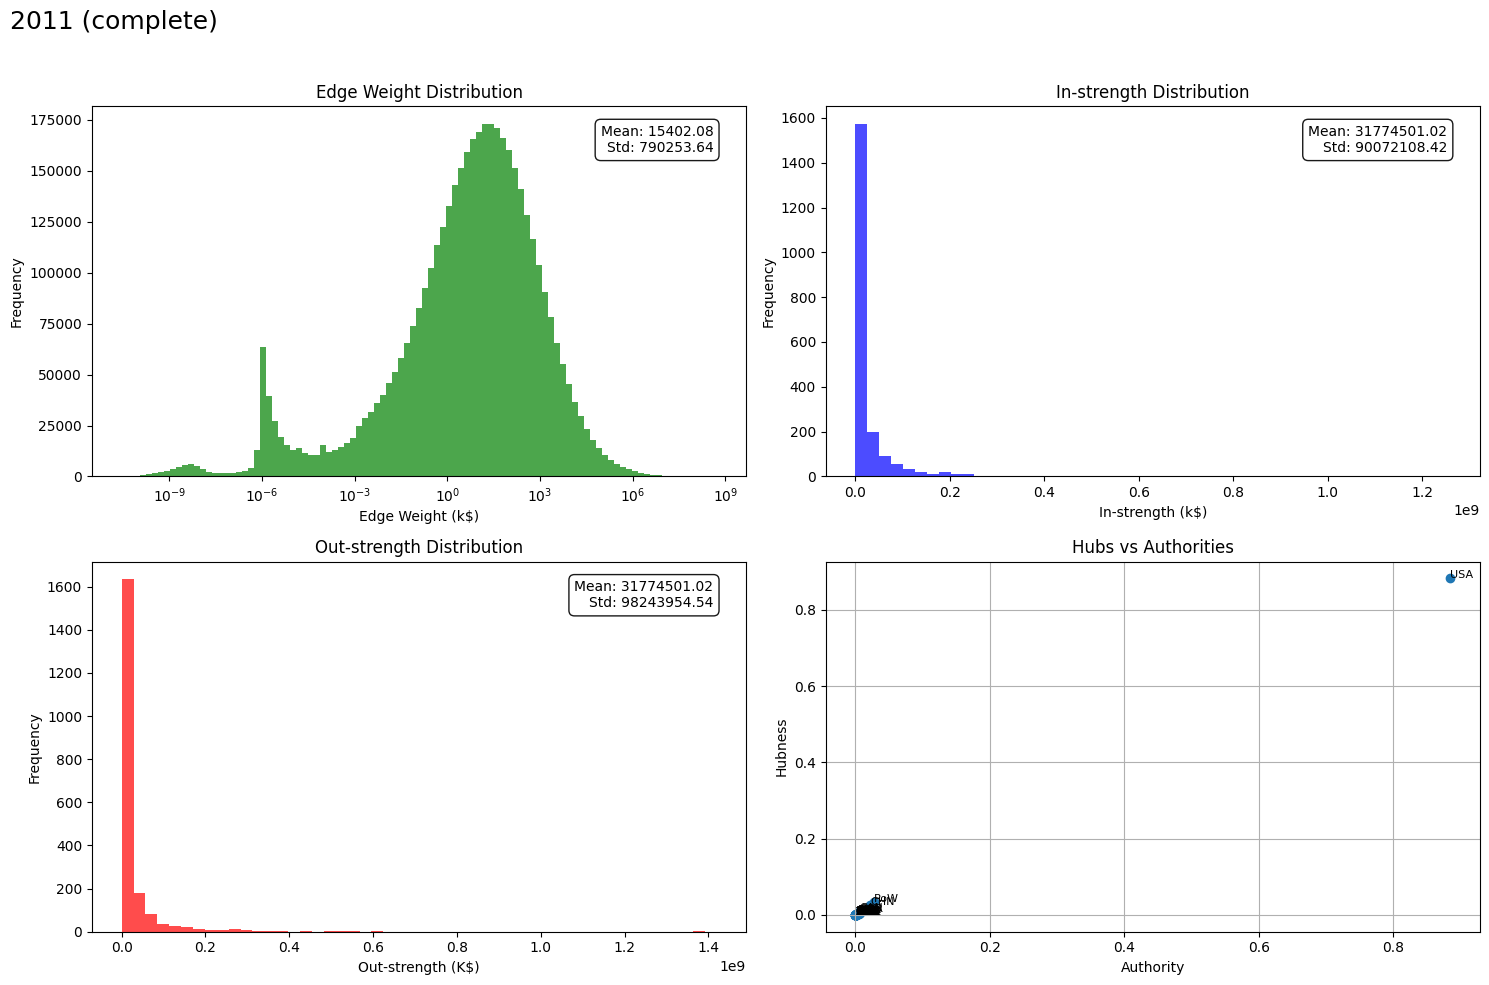

Saved: hub_aut_2011.parquet


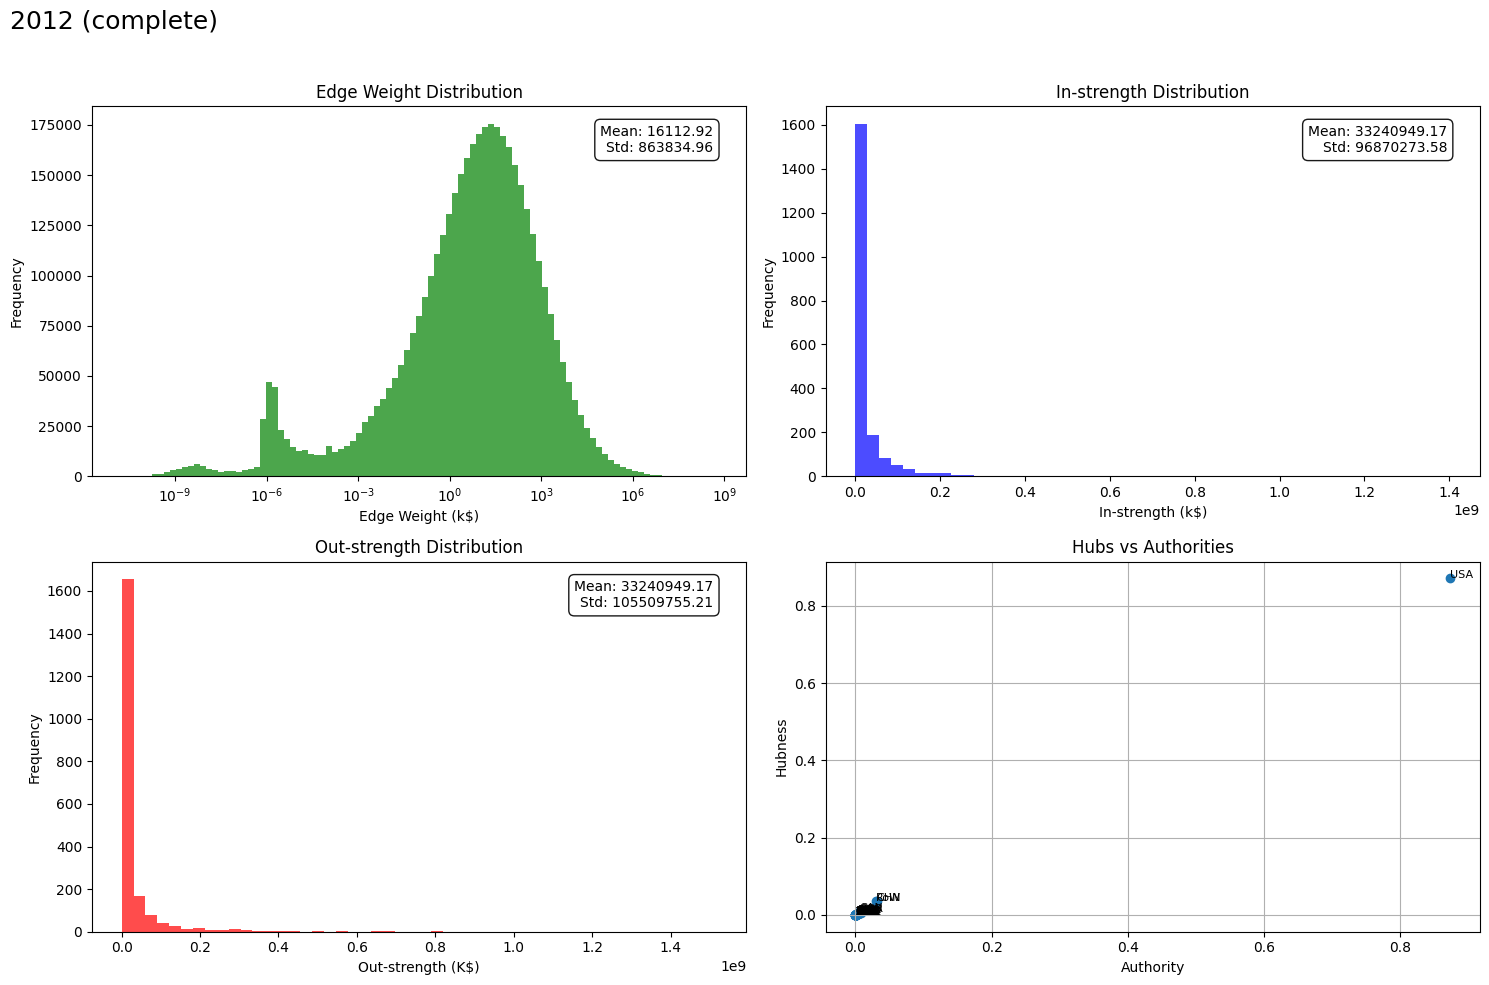

Saved: hub_aut_2012.parquet


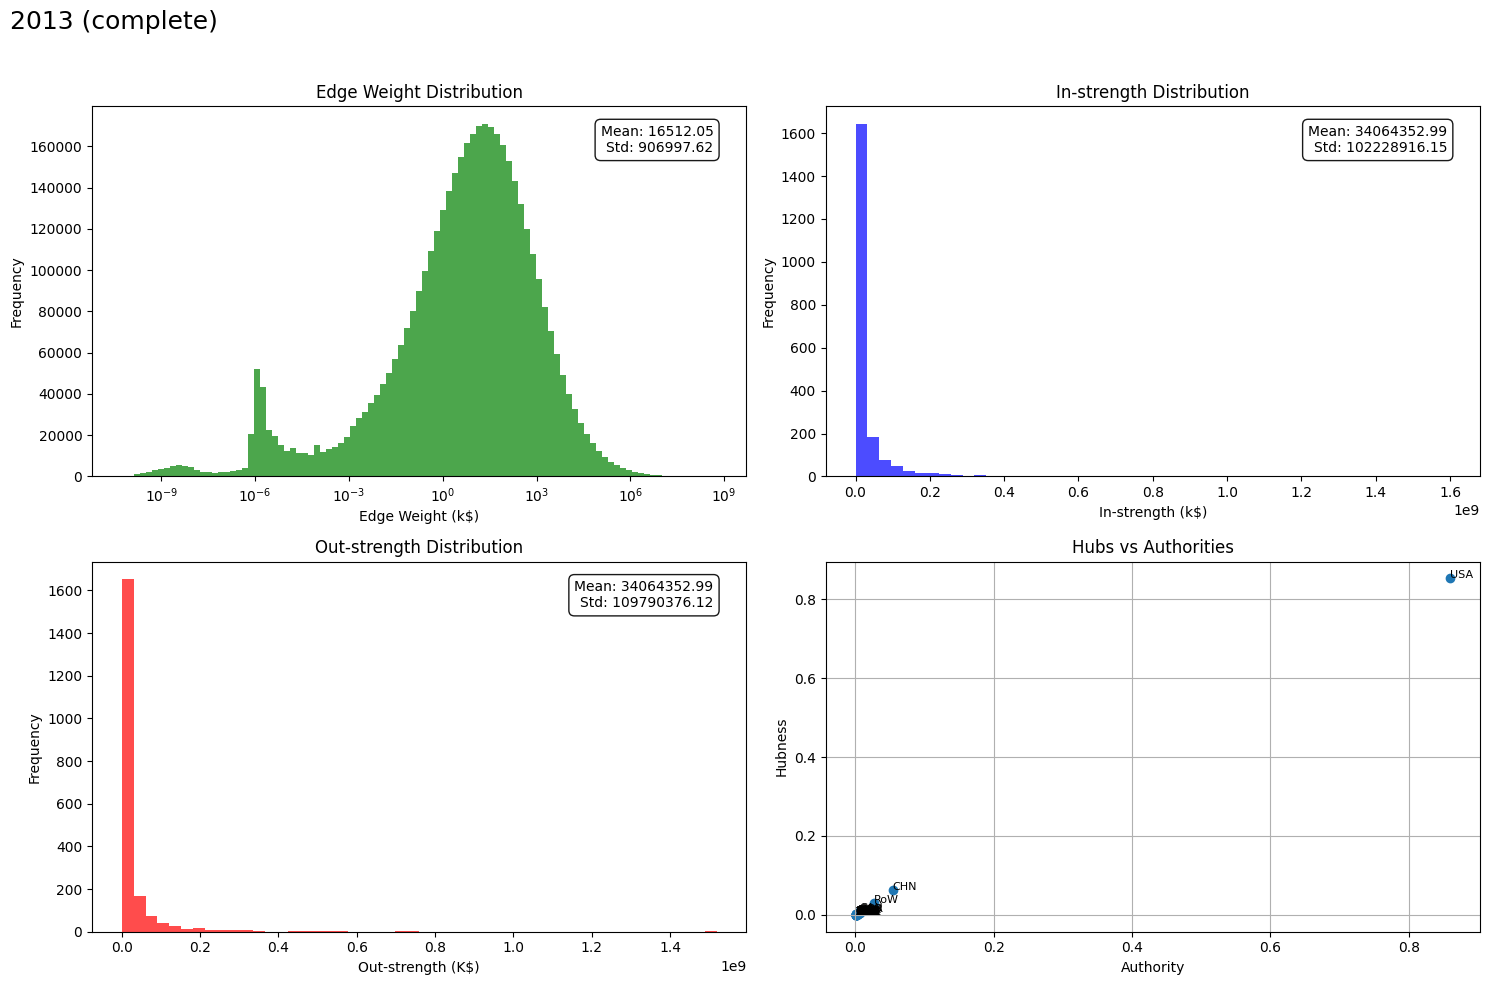

Saved: hub_aut_2013.parquet


KeyboardInterrupt: 

In [ ]:
years = range(2010, 2021)
labels = ['eu', 'gl', 'bc']
all_identifiers = list(years) + labels 
for identifier in all_identifiers:
    globals()[f"dfz_{identifier}"]  = pd.read_parquet(f'dfz_{identifier}.parquet')
    # Create the directed, weighted graph from DataFrame
    globals()[f"G_{identifier}"]= nx.from_pandas_adjacency(globals()[f"dfz_{identifier}"], create_using=nx.DiGraph)

    # Degrees
    in_degrees = dict( globals()[f"G_{identifier}"].in_degree())
    out_degrees = dict( globals()[f"G_{identifier}"].out_degree())
    in_degree_values = list(in_degrees.values())
    out_degree_values = list(out_degrees.values())

    std_in_degree = np.std(in_degree_values)
    std_out_degree = np.std(out_degree_values)

    # Check completeness
    is_complete = std_in_degree == 0 and std_out_degree == 0
    title_year = f"{identifier} (complete)" if is_complete else f"{identifier}"

    # Extract weights
    weights =  globals()[f"dfz_{identifier}"].values.flatten()
    mean_weight = np.mean(weights)
    std_weight = np.std(weights)

    # In-strength and Out-strength
    in_str = {node: sum(data['weight'] for _, _, data in globals()[f"G_{identifier}"].in_edges(node, data=True)) for node in globals()[f"G_{identifier}"].nodes}
    out_str = {node: sum(data['weight'] for _, _, data in globals()[f"G_{identifier}"].out_edges(node, data=True)) for node in globals()[f"G_{identifier}"].nodes}
    in_str_val = list(in_str.values())
    out_str_val = list(out_str.values())
    
    mean_in_str = np.mean(in_str_val)
    std_in_str = np.std(in_str_val)
    
    mean_out_str = np.mean(out_str_val)
    std_out_str = np.std(out_str_val)
    
    # Hubs and Authorities
    hub_aut = nx.hits(globals()[f"G_{identifier}"])
    hub_c = cum_count(hub_aut[0])
    aut_c = cum_count(hub_aut[1])
    keys = list(hub_c.keys())
    aut_val = [aut_c[key] for key in keys]
    hub_val = [hub_c[key] for key in keys]
    
    # --- Plotting ---
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title_year, fontsize=18, x=0.01, y=0.98, ha='left')
    
    # Box style for stats
    box_style = dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4', alpha=0.9)
    
    # 1. Edge Weight Distribution
    axs[0, 0].hist(weights, bins=np.logspace(np.log10(min(weights)), np.log10(max(weights)), 100), color='g', alpha=0.7)
    axs[0, 0].set_xscale('log')
    axs[0, 0].set_title('Edge Weight Distribution')
    axs[0, 0].set_xlabel('Edge Weight (k$)')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].text(
        0.95, 0.95,
        f'Mean: {mean_weight:.2f}\nStd: {std_weight:.2f}',
        transform=axs[0, 0].transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=box_style
    )
    
    # 2. In-strength Distribution
    axs[0, 1].hist(in_str_val, bins=50, color='b', alpha=0.7)
    axs[0, 1].set_title('In-strength Distribution')
    axs[0, 1].set_xlabel('In-strength (k$)')
    axs[0, 1].set_ylabel('Frequency')
    axs[0, 1].text(
        0.95, 0.95,
        f'Mean: {mean_in_str:.2f}\nStd: {std_in_str:.2f}',
        transform=axs[0, 1].transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=box_style
    )
    
    # 3. Out-strength Distribution
    axs[1, 0].hist(out_str_val, bins=50, color='r', alpha=0.7)
    axs[1, 0].set_title('Out-strength Distribution')
    axs[1, 0].set_xlabel('Out-strength (K$)')
    axs[1, 0].set_ylabel('Frequency')
    axs[1, 0].text(
        0.95, 0.95,
        f'Mean: {mean_out_str:.2f}\nStd: {std_out_str:.2f}',
        transform=axs[1, 0].transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=box_style
    )
    
    # 4. Hubs vs Authorities
    axs[1, 1].scatter(aut_val, hub_val)
    for i, key in enumerate(keys):
        axs[1, 1].annotate(key, (aut_val[i], hub_val[i]), fontsize=8)
    axs[1, 1].set_title('Hubs vs Authorities')
    axs[1, 1].set_xlabel('Authority')
    axs[1, 1].set_ylabel('Hubness')
    axs[1, 1].grid(True)
    
    # Layout and save
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'Base_measures_{identifier}.png', dpi=300)
    plt.show()
    
    # Save hub and authorities
    hub_scores = hub_aut[0]
    auth_scores = hub_aut[1]
    
    # Create a DataFrame
    df_hub_auth = pd.DataFrame({
        'node': list(hub_scores.keys()),
        'hub_score': list(hub_scores.values()),
        'authority_score': [auth_scores[k] for k in hub_scores.keys()]
    })
    
    # Save to Parquet
    df_hub_auth.to_parquet(f'hub_aut_{identifier}.parquet', index=False)
    print(f"Saved: hub_aut_{identifier}.parquet")